utility functions

In [1]:
%matplotlib inline
import numpy as np
import scipy.sparse as sps
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.tri as tri 
from scipy.sparse.linalg import spsolve
#from pandas import *  # for import_data function to remove duplicates.


from utils import all_edges
from utils import boundary_edges
from utils import boundary_nodes
from utils import boundary_nodes_for_p2
from utils import tplot
from utils import unique_rows

find triangle's centroid tcenter [Ux,Uy]

In [2]:
def trcent (point,tr):
    pt1 = [(point[tr[0],0]), (point[tr[0],1])]
    pt2 = [(point[tr[1],0]), (point[tr[1],1])]
    pt3 = [(point[tr[2],0]), (point[tr[2],1])]        
    tcenter = [((pt1[0] + pt2[0] + pt3[0])/3), ((pt1[1]+pt2[1]+pt3[1])/3)]
    return tcenter

check if triangles in connection table are inside polygon, eliminate if outside.

In [3]:
from matplotlib.path import Path
import numpy as np

def inboundary(pv,point,DT):
    conn = np.zeros((1,3)).astype(int)
    path = Path(pv)
    
    for i in range (0, len(DT)):
        # take triangles from connection table, call them t
        tr = [(DT[i,0]), (DT[i,1]), (DT[i,2])]
        
        tcenter = trcent(point,tr)
        
        IN = path.contains_point(tcenter)
        
        if(IN == 1):
            conn = np.append(conn, [tr], axis=0)
    conn = np.delete(conn, (0), axis=0)   
    return conn

find maximum area in all triangles in connection table, find the index of max area triangle

In [4]:
def area_max(point,DT):
    ar = [0]
    #ar = np.array((0))
    armax = 0.0
    for i in range (0, len(DT)):               
        pt1 = [(point[DT[i,0],0]), (point[DT[i,0],1])]
        pt2 = [(point[DT[i,1],0]), (point[DT[i,1],1])]
        pt3 = [(point[DT[i,2],0]), (point[DT[i,2],1])]
        
        ar.append(abs(((pt1[0]*(pt2[1]-pt3[1]))+(pt2[0]*(pt3[1]-pt1[1]))+(pt3[0]*(pt1[1]-pt2[1])))/2))
    ar = np.delete(ar, 0, axis=0)
    
    indx = np.argmax(ar)
    armax = ar[indx]
    return armax,indx

finding area of triangle from three points

In [5]:
def area(pt1,pt2,pt3):
    
    area = abs(((pt1[0]*(pt2[1]-pt3[1]))+(pt2[0]*(pt3[1]-pt1[1]))+(pt3[0]*(pt1[1]-pt2[1])))/2)
    
    return area

find circumcenter c [Ux,Uy] of any trinagle with verticies pt1[Ux,Uy], pt2[Ux,Uy], pt3[Ux,Uy]

In [6]:
def circumfind(pt1,pt2,pt3):
    #circumcenter of Triangle
    D = 2*(pt1[0]*(pt2[1]-pt3[1])+pt2[0]*(pt3[1]-pt1[1])+pt3[0]*(pt1[1]-pt2[1]))
    Ux = ((pt1[0]**2+pt1[1]**2)*(pt2[1]-pt3[1])+(pt2[0]**2+pt2[1]**2)*(pt3[1]-pt1[1])+(pt3[0]**2+pt3[1]**2)*(pt1[1]-pt2[1]))/D
    Uy = ((pt1[0]**2+pt1[1]**2)*(pt3[0]-pt2[0])+(pt2[0]**2+pt2[1]**2)*(pt1[0]-pt3[0])+(pt3[0]**2+pt3[1]**2)*(pt2[0]-pt1[0]))/D
    c = [(Ux),(Uy)]
    
    return c

find mid points mid1[Ux,Uy], mid2[Ux,Uy], mid3[Ux,Uy] of each side in a trinagle of verticies pt1[Ux,Uy], pt2[Ux,Uy], pt3[Ux,Uy]

In [7]:
def midfind(pt1,pt2,pt3):
    
    mid1 = [(pt1[0] + pt2[0])/2, (pt1[1]+pt2[1])/2]
    mid2 = [(pt2[0] + pt3[0])/2, (pt2[1]+pt3[1])/2]
    mid3 = [(pt3[0] + pt1[0])/2, (pt3[1]+pt1[1])/2]
    return mid1,mid2,mid3

meshing of whole domain. first find circumcenter of largest triangle and add it to list of points. then triangulate and eliminate triangles outside boundaries

In [8]:
def mesh_it(armax,indx,hmax,p,t,pv):
    while (armax > (hmax**2/2)):
        #finding triangle verticies
        pt1 = [(p[t[indx,0],0]), (p[t[indx,0],1])]
        pt2 = [(p[t[indx,1],0]), (p[t[indx,1],1])]
        pt3 = [(p[t[indx,2],0]), (p[t[indx,2],1])]
        #finding triangle circumcenter
        circumcenter = circumfind(pt1,pt2,pt3)
        # add circumcenter to list of points
        p = np.append(p, [circumcenter], axis=0)
        #triangulate again after adding the circumcenter of largest triangle        
        t = tri.Triangulation(p[:,0], p[:,1]).triangles
        t = inboundary(pv,p,t)
        armax,indx = area_max(p,t)
        
    return p,t

refine the mesh. finds the mid points of all triangles, add it to list of points, triangulate and remove outside triangles

In [9]:
def refine_it(p,t,pv):
    p1 = np.zeros((0,2))
    # creating nodes on boundaries
    
    for i in range(0, len(t)):
        tr = [(t[i,0]), (t[i,1]), (t[i,2])]
        #finding triangle verticies
        pt1 = [(p[tr[0],0]), (p[tr[0],1])]
        pt2 = [(p[tr[1],0]), (p[tr[1],1])]
        pt3 = [(p[tr[2],0]), (p[tr[2],1])]
        #find mid points
        mid1,mid2,mid3 = midfind(pt1,pt2,pt3)
           
        # p is the new points table
        p1 = np.append(p1, [mid1], axis=0)
        p1 = np.append(p1, [mid2], axis=0)
        p1 = np.append(p1, [mid3], axis=0)
    # removing doublicate points
    p1 = unique_rows(p1) #instead I will use the below function
    p = np.append(p, p1, axis=0)
    #p = unique_rows(p)
    #p = DataFrame(p).drop_duplicates().values
    #triangulate p to create connection table t
    t = tri.Triangulation(p[:,0], p[:,1]).triangles
    # finding if triangles inside boundary
    t = inboundary(pv,p,t)
    #t = unique_rows(t)
    return p,t

In [10]:
def pmesh(pv,hmax,nref):
    
    x = [0]
    y = [0]
    #circlist = [0]
    # creating nodes on boundaries
    for i in range(0, (len(pv)-1)):
        
        x1 = pv[i,0]
        y1 = pv[i,1]
        x2 = pv[i+1,0]
        y2 = pv[i+1,1]
        l = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        m = np.ceil(l/hmax)
        x0 = np.linspace(x1,x2,m+1)
        y0 = np.linspace(y1,y2,m+1)
        x.extend(x0)
        y.extend(y0)
    point = np.vstack([x,y])
    # p is the new points table [x,y] coordinates
    p = point.T
    # removing doublicate points
    p = unique_rows(p)
    #p = DataFrame(p).drop_duplicates().values
    #triangulate p to create connection table t
    t = tri.Triangulation(p[:,0], p[:,1]).triangles
    # finding if triangles inside boundary
    t = inboundary(pv,p,t)
    # finding area of all triangles and maximum + index relating to maximum
    # here where I discovered unique_rows messed up my p 
    # print(p)
    armax,indx = area_max(p,t)
    # meshing the domain
    p,t = mesh_it(armax,indx,hmax,p,t,pv)
    #refining the domain if href >= 1
    if (nref >= 1):
        for i in range (0, nref):
            p,t = refine_it(p,t,pv)
            armax,indx = area_max(p,t)
            p,t = mesh_it(armax,indx,hmax,p,t,pv)
    e = boundary_nodes(t,p)
    #print(p)
    return p,t,e

## a.

In [11]:
def p2mesh(p,t):
    lt = len(t)
    lp = len(p)
    ta = np.zeros((lt,3))
    t2 = np.zeros((lt,6))  # NOTE: Suggest using dtype=np.int64
    p2 = np.zeros((0,2))  
    pte = np.zeros((lp,lp))  #point to edge transform matrix, used to create t2
    # this is used to create t2, [a b], it has indices of each edge added to p2.
    edge_mid = np.zeros((0,2))  # NOTE: Ditto here on 0 rows.  
    
    for i in range(0, lt):
        #finding triangle verticies
        pt1 = [(p[t[i,0],0]), (p[t[i,0],1])]
        pt2 = [(p[t[i,1],0]), (p[t[i,1],1])]
        pt3 = [(p[t[i,2],0]), (p[t[i,2],1])]
        mid1,mid2,mid3 = midfind(pt1,pt2,pt3)
        # p is the new points table
        p2 = np.append(p2, [mid1], axis=0)
        p2 = np.append(p2, [mid2], axis=0)
        p2 = np.append(p2, [mid3], axis=0)
        # adding the indeces of each edge
        
        edge_mid = np.append(edge_mid, [[t[i,0],t[i,1]]], axis=0)
        edge_mid = np.append(edge_mid, [[t[i,1],t[i,2]]], axis=0)
        edge_mid = np.append(edge_mid, [[t[i,2],t[i,0]]], axis=0)
    
    # Sort along rows.
    edge_mid = np.sort(edge_mid, axis=1).astype(int)
    edge_mid, edge_indices = unique_rows(edge_mid, return_index=True)
    p2 = p2[edge_indices, :]

    lem = len(edge_mid)
    # creating the len(p) x len(p) matrix. contains indeces of all trinagle vertices 
    for i in range(0, lem):
        pte[edge_mid[i,0], edge_mid[i,1]] = lp + i
        pte[edge_mid[i,1], edge_mid[i,0]] = lp + i

    p2 = np.append(p, p2, axis=0) #final p2
    lp2 = len(p2)
    for i in range(0, lt):
        #finding triangle verticies
        ta[i,:] = [pte[t[i,0],t[i,1]], pte[t[i,1],t[i,2]], pte[t[i,2],t[i,0]]]
    
    t2 = np.hstack([t,ta]).astype(int)
    
    e2 = boundary_nodes_for_p2(t2, p2)  # for_realz
       
    return p2, t2, e2

## b.

fempoi2: solving poisson equation using quadratic elements

In [12]:
def fempoi2(p2,t2,e2):
    N = p2.shape[0]
    lt2 = t2.shape[0]  #length of t2 (row wise)
    m = 6
    a = np.zeros((m,m))  # sps.lil_matrix((m, m))
    Ah = np.zeros((m,m)) #sps.lil_matrix((m, m))
    bh = np.zeros((m))
    A = sps.lil_matrix((N, N)) #np.zeros((N,N)) #sps.lil_matrix((N, N))
    b = np.zeros((N))
    a[0,:] = 1.0
    
    Xg = np.zeros((3,2))  #gaussian vectors Xg[i,:] = [xgi,ygi]
    X  = np.zeros((3,2))  #vectors X[i,:] = [xi,yi]
    
    for k in range(0, lt2):
        x1 = p2[t2[k,0],0]
        x2 = p2[t2[k,1],0]
        x3 = p2[t2[k,2],0]
        x4 = p2[t2[k,3],0]
        x5 = p2[t2[k,4],0]
        x6 = p2[t2[k,5],0]
        y1 = p2[t2[k,0],1]
        y2 = p2[t2[k,1],1]
        y3 = p2[t2[k,2],1]
        y4 = p2[t2[k,3],1]
        y5 = p2[t2[k,4],1]
        y6 = p2[t2[k,5],1]
        a[1,:] = [(x1),(x2),(x3),(x4),(x5),(x6)]
        a[2,:] = [(y1),(y2),(y3),(y4),(y5),(y6)]
        a[3,:] = [(x1**2),(x2**2),(x3**2),(x4**2),(x5**2),(x6**2)] 
        a[4,:] = [(y1**2),(y2**2),(y3**2),(y4**2),(y5**2),(y6**2)]
        a[5,:] = [(x1*y1),(x2*y2),(x3*y3),(x4*y4),(x5*y5),(x6*y6)]
        
        el = t2[k,:3]
        Q = np.hstack((np.ones((3,1)), p2[el,:]))
        Area = abs(np.linalg.det(Q)) / 2.0
        
        F = np.linalg.inv(a)
        #F = spsolve(a1.tocsc(), I6) # 0 1  2   3  4  5
        # F[0,:] is in the form of: [a1,b1,c1,d1,e1,f1]
        # assiging corner points in triangle k
        X[0,:] = [(p2[t2[k,0],0]),  (p2[t2[k,0],1])]
        X[1,:] = [(p2[t2[k,1],0]),  (p2[t2[k,1],1])]
        X[2,:] = [(p2[t2[k,2],0]),  (p2[t2[k,2],1])]
            
        Xg[0,:] = [(((2./3)*X[0,0])+X[1,0]/6+X[2,0]/6), (((2./3)*X[0,1])+X[1,1]/6+X[2,1]/6)]
        Xg[1,:] = [((X[0,0])/6+(2./3)*X[1,0]+X[2,0]/6), ((X[0,1]/6)+(2./3)*X[1,1]+X[2,1]/6)]
        Xg[2,:] = [((X[0,0])/6+X[1,0]/6+(2./3)*X[2,0]), ((X[0,1])/6+X[1,1]/6+(2./3)*X[2,1])]
        
        for i in range(0, m):
            for j in range(0,m):
                #   dHix = F[i,1]+(2*F[i,3])*Xg[l,0]+(F[i,5])*Xg[l,1] 
                #   dHjx = F[j,1]+(2*F[j,3])*Xg[l,0]+(F[j,5])*Xg[l,1]
                #   dHiy = F[i,2]+(F[i,5])*Xg[l,0]+(2*F[i,4])*Xg[l,1] 
                #   dHjy = F[j,2]+(F[j,5])*Xg[l,0]+(2*F[j,4])*Xg[l,1]
                #(dHix * dHjx + dHiy * dHjy) at Xg1
                          #dHidHj at Xg1
                sumdHidHj =((F[i,1]+(2*F[i,3])*Xg[0,0]+(F[i,5])*Xg[0,1])*(F[j,1]+(2*F[j,3])*Xg[0,0]+(F[j,5])*Xg[0,1]) + \
                            (F[i,2]+(F[i,5])*Xg[0,0]+(2*F[i,4])*Xg[0,1])*(F[j,2]+(F[j,5])*Xg[0,0]+(2*F[j,4])*Xg[0,1]) + 
                          #dHidHj at Xg2
                           (F[i,1]+(2*F[i,3])*Xg[1,0]+(F[i,5])*Xg[1,1])*(F[j,1]+(2*F[j,3])*Xg[1,0]+(F[j,5])*Xg[1,1]) + \
                           (F[i,2]+(F[i,5])*Xg[1,0]+(2*F[i,4])*Xg[1,1])*(F[j,2]+(F[j,5])*Xg[1,0]+(2*F[j,4])*Xg[1,1]) + \
                          #dHidHj at Xg3
                           (F[i,1]+(2*F[i,3])*Xg[2,0]+(F[i,5])*Xg[2,1])*(F[j,1]+(2*F[j,3])*Xg[2,0]+(F[j,5])*Xg[2,1]) + \
                           (F[i,2]+(F[i,5])*Xg[2,0]+(2*F[i,4])*Xg[2,1])*(F[j,2]+(F[j,5])*Xg[2,0]+(2*F[j,4])*Xg[2,1]) )
                Ah[i,j] = (Area/3)* sumdHidHj
    
                    #Hi at Xg1
            sumHi = (F[i,0]+F[i,1]*Xg[0,0]+F[i,2]*Xg[0,1]+F[i,3]*(Xg[0,0])**2+F[i,4]*(Xg[0,1])**2+F[i,5]*Xg[0,0]*Xg[0,1] + \
                    #Hi at Xg2
                     F[i,0]+F[i,1]*Xg[1,0]+F[i,2]*Xg[1,1]+F[i,3]*(Xg[1,0])**2+F[i,4]*(Xg[1,1])**2+F[i,5]*Xg[1,0]*Xg[1,1] + \
                    # Hi at Xg3
                     F[i,0]+F[i,1]*Xg[2,0]+F[i,2]*Xg[2,1]+F[i,3]*(Xg[2,0])**2+F[i,4]*(Xg[2,1])**2+F[i,5]*Xg[2,0]*Xg[2,1])
                    #sumHi = sumHi + Hi
            bh[i] = (Area/3)*sumHi
        
        #stamping A and b with Ah and bh
        el2 = t2[k,:]
        
        A[np.ix_(el2,el2)] += Ah
        b[el2] += bh
    
    # Implement Dirichlet boundary conditions
    A[e2,:] = 0.0
    A[:,e2] = 0.0
    A[e2, e2] = 1.0
    b[e2] = 0.0
    
    # Solve
    u = spsolve(A.tocsc(), b)
    return u, A, b

## c.

convergence study..

In [13]:
hmax = 0.3
pv = np.array([[0.0,0.0],[1.0,0.0],[1.0,1.0],[0.0,1.0],[0.0,0.0]])

In [14]:
#case 1:
nref = 0  
p,t,e = pmesh(pv,hmax,nref)
p2, t2, e2 = p2mesh(p,t)
u0, A, b= fempoi2(p2,t2,e2)
N = len(p)

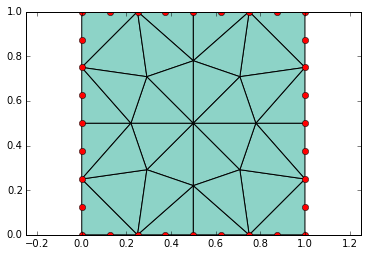

In [15]:
tplot(p,t)
plt.plot(p2[e2,0], p2[e2, 1], 'ro')
plt.show()

In [16]:
#case 2:
nref = 1
p,t,e = pmesh(pv,hmax,nref)
p2, t2, e2 = p2mesh(p,t)
u1, A, b = fempoi2(p2,t2,e2)

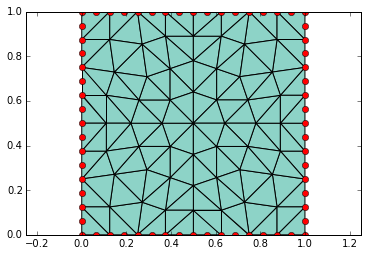

In [17]:
tplot(p,t)
plt.plot(p2[e2,0], p2[e2, 1], 'ro')
plt.show()

In [18]:
#case 3:
nref = 2
p,t,e = pmesh(pv,hmax,nref)
p2, t2, e2 = p2mesh(p,t)
u2, A, b = fempoi2(p2,t2,e2)

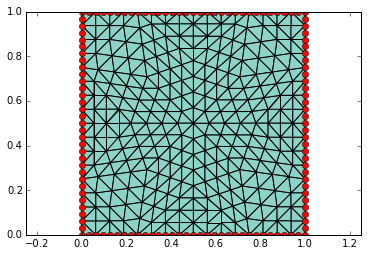

In [19]:
tplot(p,t)
plt.plot(p2[e2,0], p2[e2, 1], 'ro')
plt.show()

In [20]:
#case 4:
nref = 3
p,t,e = pmesh(pv,hmax,nref)
p2, t2, e2 = p2mesh(p,t)
u3, A, b = fempoi2(p2,t2,e2)

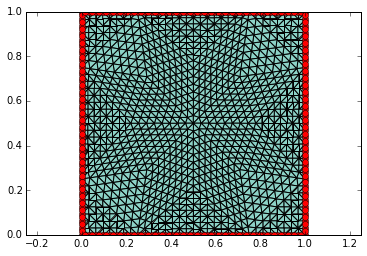

In [21]:
tplot(p,t)
plt.plot(p2[e2,0], p2[e2, 1], 'ro')
plt.show()

In [22]:
#exact case: nref = 4
nref = 4
p,t,e = pmesh(pv,hmax,nref)
p2, t2, e2 = p2mesh(p,t)
u4, A, b = fempoi2(p2,t2,e2)

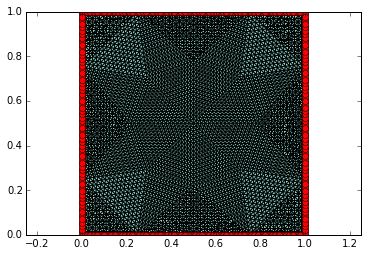

In [23]:
tplot(p,t)
plt.plot(p2[e2,0], p2[e2, 1], 'ro')
plt.show()

calculating the error

In [24]:
u01 = u0[0:N]
u11 = u1[0:N]
u21 = u2[0:N]
u31 = u3[0:N]
u41 = u4[0:N]

In [25]:
e0 = max(abs(u41-u01))
e1 = max(abs(u41-u11))
e2 = max(abs(u41-u21))
e3 = max(abs(u41-u31))
Er = np.array([e0,e1,e2,e3])
dh = np.array([hmax,hmax/2,1./4*hmax,1./8*hmax])

In [26]:
print(Er)

[  1.12386400e-04   1.54550943e-05   1.96491425e-06   2.21712912e-07]


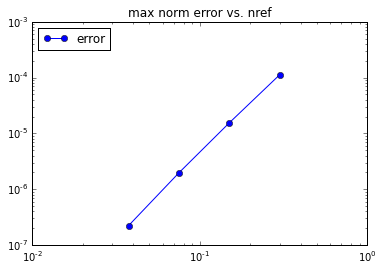

In [27]:
plt.title('max norm error vs. nref')
L1,=plt.loglog(dh,Er,label='error',lw=1,marker='o')
Leg1=plt.legend(handles=[L1],loc=2)
plt.show()

In [28]:
slope, intercept = np.polyfit(np.log(dh),np.log(Er), 1) 
print ('order of convergence: ',slope)

order of convegence:  2.99322210569


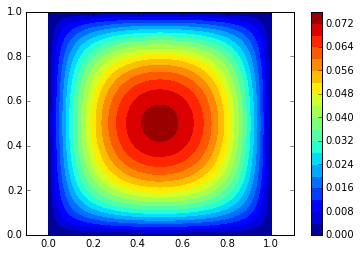

In [29]:
tplot(p,t,u4[0:len(p)])